### Problem and motivation

**Motivation and Problem**: 
Our client is a food publication company that has a lot of recipes. 
These recipes are supplied as lists of ingredients. 
We need users to be able to query recipes by cuisine. 

**The data**
More than 39,000 recipe ingredient lists, labeled with one of 20 cuisines.

**The task**
Use labeled data set (describe above) to train model to predict cuisince given ingredients from recipes. 

**The model**: A logistic regression model predicts cuisine from recipe ingredients with 74% accuracy (tested on 20% of data, removed prior to training). It does better on those cuisines which are over-represented in the data.

**Outstanding challenges**: Ingredient list currently includes "descriptive" words, making similar ingredients be seen as two distinct ingredients. 


### Load packages and data

In [1]:
#Load necessary packages
import os
import pandas as pd

#Import sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

#Import matplotlib
import matplotlib.pyplot as plt

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load data
os.getcwd()
os.chdir("/Users/Olga/Documents/INSIGHT2019/DataChallenge")
recipes_DF = pd.read_json('recipies.json')

### Data exploration

In [3]:
#Look at data structure
print("dataframe:", recipes_DF.head(10))
print("columns present:", recipes_DF.columns)
print("data types:", recipes_DF.dtypes)
print("data shape:", recipes_DF.shape)

dataframe:        cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...
5     jamaican   6602  [plain flour, sugar, butter, eggs, fresh ginge...
6      spanish  42779  [olive oil, salt, medium shrimp, pepper, garli...
7      italian   3735  [sugar, pistachio nuts, white almond bark, flo...
8      mexican  16903  [olive oil, purple onion, fresh pineapple, por...
9      italian  12734  [chopped tomatoes, fresh basil, garlic, extra-...
columns present: Index(['cuisine', 'id', 'ingredients'], dtype='object')
data types: cuisine        object
id              int64
ingredients    object
dtype: object
data shape: (39774, 3

In [4]:
#Recipe ID will not be useful; delete
recipes_DF_noID = recipes_DF.drop(["id"], axis = 1)

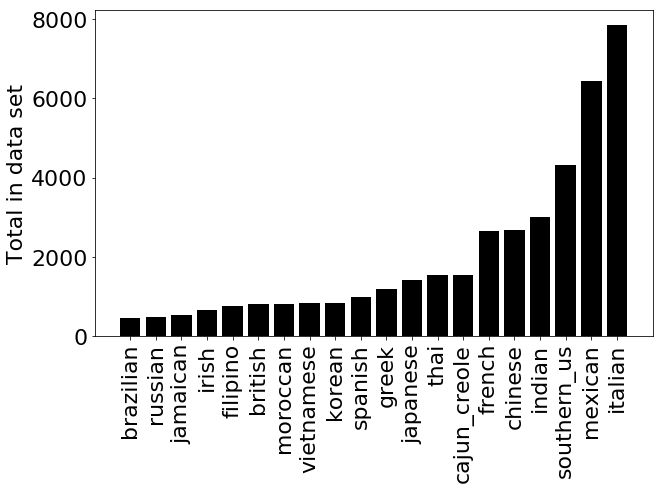

In [5]:
#Count number of times a cuisine occurs
cuisinelist = recipes_DF_noID.cuisine.unique()
sum_of_cuisine = []
for cuisine in cuisinelist:
    sum_of_cuisine.append(sum(list(recipes_DF_noID.cuisine == cuisine)))
                          
cuisine_tot_df = pd.DataFrame(list(zip(cuisinelist, sum_of_cuisine)), columns = ('cuisine', 'sumcuisine'))

cuisine_tot_df_sort = cuisine_tot_df.sort_values('sumcuisine')

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 22})
plt.bar(cuisine_tot_df_sort.cuisine,  cuisine_tot_df_sort.sumcuisine, color = "black")
plt.xticks(rotation=90)
plt.ylabel('Total in data set')
plt.show()


In [267]:
#How accurate are we if we always predict Italian (majority class)?
sum(list(recipes_DF_noID.cuisine == 'italian'))/recipes_DF_noID.shape[0]

0.19706340825665009

### Prep data for modeling: one hot encode recipe ingredients using  bag of words 

In [9]:
#Need to convert list of ingredients to separate strings for bag of words
recipes_DF_noID['ingredient_transformed'] = recipes_DF_noID['ingredients'].apply(lambda x: ', '.join(x))
recipes_DF_noID.head(10)

,cuisine,ingredients,ingredient_transformed
0,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce, black olives, grape tomatoes,..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour, ground pepper, salt, tomatoes, gr..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs, pepper, salt, mayonaise, cooking oil, gr..."
3,indian,"[water, vegetable oil, wheat, salt]","water, vegetable oil, wheat, salt"
4,indian,"[black pepper, shallots, cornflour, cayenne pe...","black pepper, shallots, cornflour, cayenne pep..."
5,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...","plain flour, sugar, butter, eggs, fresh ginger..."
6,spanish,"[olive oil, salt, medium shrimp, pepper, garli...","olive oil, salt, medium shrimp, pepper, garlic..."
7,italian,"[sugar, pistachio nuts, white almond bark, flo...","sugar, pistachio nuts, white almond bark, flou..."
8,mexican,"[olive oil, purple onion, fresh pineapple, por...","olive oil, purple onion, fresh pineapple, pork..."
9,italian,"[chopped tomatoes, fresh basil, garlic, extra-...","chopped tomatoes, fresh basil, garlic, extra-v..."


In [10]:
#Need to make list of all unique ingredients
all_ingredients = []
for i in range(recipes_DF_noID.shape[0]):
    all_ingredients.append(recipes_DF_noID.loc[i, 'ingredients'])
    
flat_all_ingredients = [item for sublist in all_ingredients for item in sublist]
    
print(len(flat_all_ingredients))
unique_ingredients = set(flat_all_ingredients)
print(len(unique_ingredients))

428275
6714


In [67]:
#Use bag of words to one hot encode all 6,714 unique ingredients
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(vocabulary = list(unique_ingredients))  
bag_of_words3 = count_vectorizer.fit_transform(recipes_DF_noID['ingredient_transformed'])

### Prep data for modeling: Factorize cuisines

In [28]:
#Convert cuisines to numeric 

#How many unique cuisines are there?
print(recipes_DF_noID.cuisine.unique())
print(len(recipes_DF_noID.cuisine.unique()))

#Factorize cuisines (convert to numbers).
type(pd.factorize(recipes_DF_noID.cuisine)[0])
#Verify that factorization worked. 
checkcuisinefact_df = pd.DataFrame(pd.factorize(recipes_DF_noID.cuisine)[0], recipes_DF_noID.cuisine)
print(checkcuisinefact_df.head(10))

['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']
20
             0
cuisine       
greek        0
southern_us  1
filipino     2
indian       3
indian       3
jamaican     4
spanish      5
italian      6
mexican      7
italian      6


### Model #1: Logistic regression

In [66]:
#Run logistic regression. Train on 80% of data, test on 20% of data.
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
X_train, X_test, y_train, y_test = train_test_split(bag_of_words3, pd.factorize(recipes_DF_noID.cuisine)[0], test_size = 0.2, random_state = 11)
logreg.fit(X_train, y_train)
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

0.7786228354128036
0.742049025769956


### Model #1 results: a closer look
1. What are the cuisines that this model gets wrong?

In [16]:
#What are the cuisines that this model gets wrong? - Build appropriate data frame
Prediction_actual_df = pd.DataFrame(list(zip(logreg.predict(X_test), y_test)), columns = ['Predicted', 'Actual'])
Prediction_actual_df['PredictCorrect'] = list(Prediction_actual_df['Predicted'] == Prediction_actual_df['Actual'])
Prediction_actual_df.head(10)

,Predicted,Actual,PredictCorrect
0,8,8,True
1,12,12,True
2,8,8,True
3,6,6,True
4,3,3,True
5,7,5,False
6,14,16,False
7,1,1,True
8,7,7,True
9,6,14,False


In [17]:
#What are the cuisines that this model gets wrong?
cuisine_type_by_number = list(Prediction_actual_df.Actual.unique())

list_of_cuisines = []
list_of_true = []
list_of_false = []

for cuisine in cuisine_type_by_number:
    TEMPDF = Prediction_actual_df[Prediction_actual_df.Actual == cuisine]
    list_of_cuisines.append(cuisine)
    list_of_true.append(len(TEMPDF[TEMPDF.PredictCorrect == 1].index))
    list_of_false.append(len(TEMPDF[TEMPDF.PredictCorrect == 0].index))
    

In [18]:
print(list_of_cuisines)
print(list_of_true)
print(list_of_false)

True_False_DF = pd.DataFrame(list(zip(list_of_cuisines, list_of_true, list_of_false)), columns = ['Cuisine', "NumCorrect", "NumIncorrect"])
True_False_DF['sumCorrectIncorrect'] = True_False_DF.NumCorrect + True_False_DF.NumIncorrect

[8, 12, 6, 3, 5, 16, 1, 7, 14, 0, 10, 19, 2, 17, 15, 18, 11, 9, 13, 4]
[467, 180, 1358, 517, 74, 64, 627, 1134, 281, 139, 218, 35, 82, 130, 231, 112, 87, 70, 35, 62]
[95, 124, 221, 78, 117, 76, 226, 146, 220, 107, 93, 55, 70, 44, 81, 41, 65, 101, 50, 42]


In [29]:
checkcuisinefact_df.reset_index(level=0, inplace=True)
cuisine_name_num = checkcuisinefact_df.groupby(by = ['cuisine'], as_index=False).first()
cuisine_name_num.columns = ('cuisine_name', 'cuisine')
cuisine_name_num

,cuisine_name,cuisine
0,brazilian,13
1,british,9
2,cajun_creole,12
3,chinese,8
4,filipino,2
5,french,14
6,greek,0
7,indian,3
8,irish,16
9,italian,6


In [30]:
cuisine_list = cuisine_name_num.cuisine.unique()
True_False_DF['cuisine_name'] = ''
for cuisine in cuisine_list:
    idx = True_False_DF[True_False_DF.Cuisine == cuisine].index
    idx2 = cuisine_name_num[cuisine_name_num.cuisine == cuisine].index
    name = cuisine_name_num.loc[idx2[0], 'cuisine_name']
    True_False_DF.loc[idx, 'cuisine_name'] = str(name)

In [31]:
 True_False_DF_sorted = True_False_DF.sort_values(by=['sumCorrectIncorrect'], ascending=True)

In [32]:
True_False_DF_sorted

,Cuisine,NumCorrect,NumIncorrect,sumCorrectIncorrect,cuisine_name
18,13,35,50,85,brazilian
11,19,35,55,90,russian
19,4,62,42,104,jamaican
5,16,64,76,140,irish
16,11,87,65,152,vietnamese
12,2,82,70,152,filipino
15,18,112,41,153,moroccan
17,9,70,101,171,british
13,17,130,44,174,korean
4,5,74,117,191,spanish


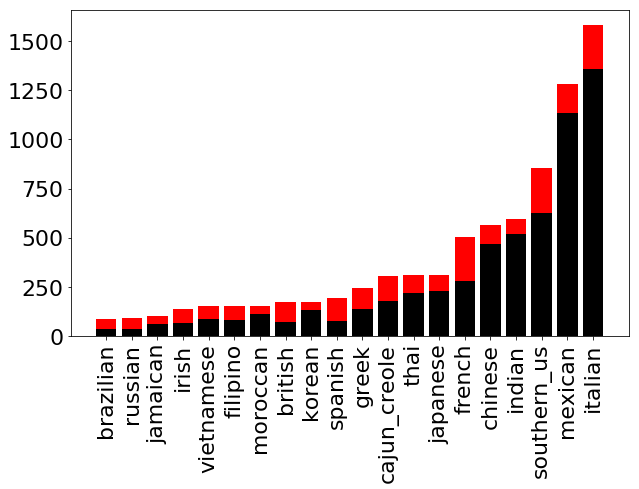

In [33]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 22})
plt.bar(True_False_DF_sorted.cuisine_name,  True_False_DF_sorted.NumCorrect, color = "black")
plt.bar(True_False_DF_sorted.cuisine_name,  True_False_DF_sorted.NumIncorrect, color = "red", bottom=True_False_DF_sorted.NumCorrect)
plt.xticks(rotation=90)
plt.ylabel('')
plt.show()
    
    

In [151]:
#Sort by fraction wrong. 


In [147]:
True_False_DF_sorted_second['FractWrong'] = True_False_DF_sorted['NumIncorrect']/True_False_DF_sorted['sumCorrectIncorrect']

In [148]:
True_False_DF_sorted_second = True_False_DF_sorted_second.sort_values(by = "FractWrong", ascending = False)

In [149]:
True_False_DF_sorted_second

,Cuisine,NumCorrect,NumIncorrect,sumCorrectIncorrect,cuisine_name,FractWrong
4,5,74,117,191,spanish,0.612565
11,19,35,55,90,russian,0.611111
17,9,70,101,171,british,0.590643
18,13,35,50,85,brazilian,0.588235
5,16,64,76,140,irish,0.542857
12,2,82,70,152,filipino,0.460526
8,14,281,220,501,french,0.439122
9,0,139,107,246,greek,0.434959
16,11,87,65,152,vietnamese,0.427632
1,12,180,124,304,cajun_creole,0.407895


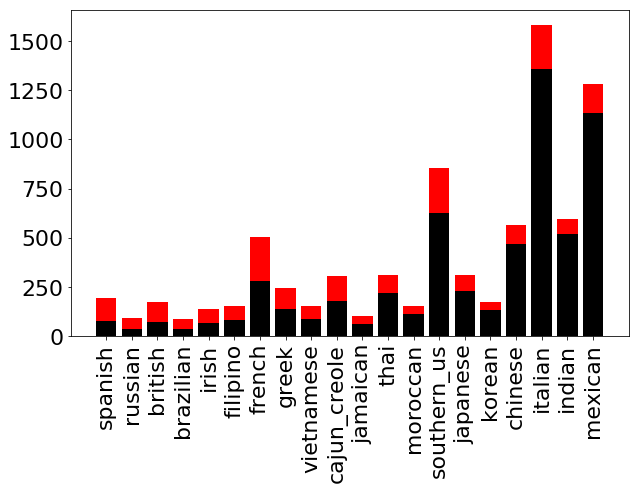

In [150]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 22})
plt.bar(True_False_DF_sorted_second.cuisine_name,  True_False_DF_sorted_second.NumCorrect, color = "black")
plt.bar(True_False_DF_sorted_second.cuisine_name,  True_False_DF_sorted_second.NumIncorrect, color = "red", bottom=True_False_DF_sorted_second.NumCorrect)
plt.xticks(rotation=90)
plt.ylabel('')
plt.show()

In [34]:
#Logistic regression metrics
sum(True_False_DF_sorted.NumIncorrect)/sum(True_False_DF_sorted.sumCorrectIncorrect)

0.257950974230044

In [ ]:
#What are different cuisines confused with? 

### Model #2: Random forest
1. Does a random forest perform better that logistic regession? (Allows for nonlinear relationships). 

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

rfcmodel = RandomForestClassifier(n_estimators=100, max_features = "sqrt")
rfcmodel.fit(X_train, y_train)
RFresultDF = pd.DataFrame(list(zip(rfcmodel.predict(X_test), y_test)))
rfcmodel.score(X_test, y_test)

0.7326209930861094

In [36]:
RFresultDF.columns = ('Predicted', 'Actual')
RFresultDF['PredictCorrest'] = list(RFresultDF['Predicted'] == RFresultDF['Actual'])
print(RFresultDF.head(10))

   Predicted  Actual  PredictCorrest
0          8       8            True
1         12      12            True
2          8       8            True
3          6       6            True
4          3       3            True
5          7       5           False
6         14      16           False
7          1       1            True
8          7       7            True
9         14      14            True


In [37]:
#What are the cuisines that this model gets wrong?
cuisine_type_by_number = list(RFresultDF.Actual.unique())

list_of_cuisines_RF = []
list_of_true_RF = []
list_of_false_RF = []

for cuisine in cuisine_type_by_number:
    TEMPDF_RF = RFresultDF[RFresultDF.Actual == cuisine]
    list_of_cuisines_RF.append(cuisine)
    list_of_true_RF.append(len(TEMPDF_RF[TEMPDF_RF.PredictCorrest == 1].index))
    list_of_false_RF.append(len(TEMPDF_RF[TEMPDF_RF.PredictCorrest == 0].index))

In [38]:
True_False_DF_RF = pd.DataFrame(list(zip(list_of_cuisines_RF, list_of_true_RF, list_of_false_RF)), columns = ['Cuisine', "NumCorrect", "NumIncorrect"])
True_False_DF_RF['sumCorrectIncorrect'] = True_False_DF_RF.NumCorrect + True_False_DF_RF.NumIncorrect

print(True_False_DF_RF.head(10))


   Cuisine  NumCorrect  NumIncorrect  sumCorrectIncorrect
0        8         472            90                  562
1       12         193           111                  304
2        6        1434           145                 1579
3        3         535            60                  595
4        5          56           135                  191
5       16          53            87                  140
6        1         641           212                  853
7        7        1158           122                 1280
8       14         252           249                  501
9        0         109           137                  246


In [39]:
cuisine_list = cuisine_name_num.cuisine.unique()
True_False_DF_RF['cuisine_name'] = ''
for cuisine in cuisine_list:
    idx = True_False_DF_RF[True_False_DF_RF.Cuisine == cuisine].index
    idx2 = cuisine_name_num[cuisine_name_num.cuisine == cuisine].index
    name = cuisine_name_num.loc[idx2[0], 'cuisine_name']
    True_False_DF_RF.loc[idx, 'cuisine_name'] = str(name)
True_False_DF_sorted_RF = True_False_DF_RF.sort_values(by=['sumCorrectIncorrect'], ascending=True)

In [40]:
print(True_False_DF_sorted_RF.head(10))

    Cuisine  NumCorrect  NumIncorrect  sumCorrectIncorrect cuisine_name
18       13          31            54                   85    brazilian
11       19          24            66                   90      russian
19        4          54            50                  104     jamaican
5        16          53            87                  140        irish
16       11          73            79                  152   vietnamese
12        2          69            83                  152     filipino
15       18          91            62                  153     moroccan
17        9          49           122                  171      british
13       17         107            67                  174       korean
4         5          56           135                  191      spanish


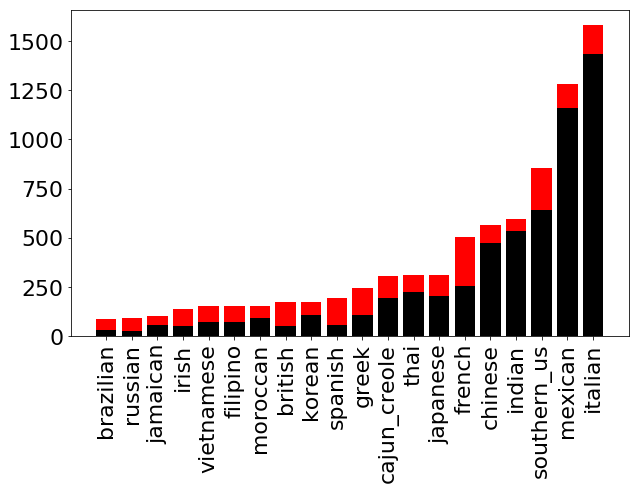

In [41]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 22})
plt.bar(True_False_DF_sorted_RF.cuisine_name,  True_False_DF_sorted_RF.NumCorrect, color = "black")
plt.bar(True_False_DF_sorted_RF.cuisine_name,  True_False_DF_sorted_RF.NumIncorrect, color = "red", bottom=True_False_DF_sorted_RF.NumCorrect)
plt.xticks(rotation=90)
plt.ylabel('')
plt.show()

In [42]:
#Compare Log regression to Random Forest
#Random forest metrics
print("Random forest metrics:")
print(1-sum(True_False_DF_sorted_RF.NumIncorrect)/sum(True_False_DF_sorted_RF.sumCorrectIncorrect))
#Log regression metrics
print("Log regression metrics:")
print(1-sum(True_False_DF_sorted.NumIncorrect)/sum(True_False_DF_sorted.sumCorrectIncorrect))

Random forest metrics:
0.7326209930861094
Log regression metrics:
0.742049025769956


In [43]:
#Is RF overfit??
#YES, random forest is overfit!
print("Score for test set")
print(rfcmodel.score(X_test, y_test))
print("Score for train set")
print(rfcmodel.score(X_train, y_train))

Score for test set
0.7326209930861094
Score for train set
0.9969200791979634


In [44]:
#Try to reduce RF overfitting. Didn't work very well. 
rfcmodel_2 = RandomForestClassifier(n_estimators=100, max_features = "sqrt", max_depth = 30)
rfcmodel_2.fit(X_train, y_train)
RFresultDF_2 = pd.DataFrame(list(zip(rfcmodel.predict(X_test), y_test)))
print(rfcmodel_2.score(X_test, y_test))
print(rfcmodel_2.score(X_train, y_train))

rfcmodel_2 = RandomForestClassifier(n_estimators=100, max_features = "sqrt", max_depth = 40)
rfcmodel_2.fit(X_train, y_train)
RFresultDF_2 = pd.DataFrame(list(zip(rfcmodel.predict(X_test), y_test)))
print(rfcmodel_2.score(X_test, y_test))
print(rfcmodel_2.score(X_train, y_train))

rfcmodel_2 = RandomForestClassifier(n_estimators=100, max_features = "sqrt", max_depth = 50)
rfcmodel_2.fit(X_train, y_train)
RFresultDF_2 = pd.DataFrame(list(zip(rfcmodel.predict(X_test), y_test)))
print(rfcmodel_2.score(X_test, y_test))
print(rfcmodel_2.score(X_train, y_train))

rfcmodel_2 = RandomForestClassifier(n_estimators=100, max_features = "sqrt", max_depth = 60)
rfcmodel_2.fit(X_train, y_train)
RFresultDF_2 = pd.DataFrame(list(zip(rfcmodel.predict(X_test), y_test)))
print(rfcmodel_2.score(X_test, y_test))
print(rfcmodel_2.score(X_train, y_train))


0.6497800125707103
0.7947138502152802
0.6896291640477688
0.8985197523492253
0.7087366436203646
0.9494013011094
0.7204274041483344
0.9756434834532827


In [ ]:
### WHAT IS MODEL GETTING WRONG???

#Most common words per cuisine

### Logistic regression works as well as random forest, so let's continue with logistic regression

In [45]:
#Ingredients that are not frequent are not useful for model, and may actually make model worse. 
#Let's remove those
o_list = []
for i in range(len(list(unique_ingredients))):
    o_list.append(flat_all_ingredients.count(list(unique_ingredients)[i]))
    
ingredient_frequency = pd.DataFrame(list(zip(list(unique_ingredients), o_list)), columns = ('ingredients', 'frequency')).sort_values('frequency', ascending = False).reset_index(drop = True)


(6714, 2)
(6636, 2)


In [47]:
print(ingredient_frequency.shape)
print(ingredient_frequency[ingredient_frequency.frequency < 1000].shape)
print(ingredient_frequency[ingredient_frequency.frequency < 50].shape)

(6714, 2)
(6636, 2)
(5718, 2)


In [58]:
#5718/6636 ingredients come less that 50 times in whole dataset. 
less_than_50_words = list(set(ingredient_frequency[ingredient_frequency.frequency < 50].ingredients.tolist()))
vocabulary_nonelessthatn50 = list(set(list(unique_ingredients)) - set(less_than_50_words))

#make sure this worked
print(len(list(unique_ingredients)))
print(len(less_than_50_words))
print(len(vocabulary_nonelessthatn50))

#this leaves us with 996 words

6714
5718
996


In [61]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(vocabulary = vocabulary_nonelessthatn50)  
bag_of_words4 = count_vectorizer.fit_transform(recipes_DF_noID['ingredient_transformed'])

In [62]:
#Run logistic regression. Train on 80% of data, test on 20% of data.
#Actually, does a bit worse. 
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
X_train, X_test, y_train, y_test = train_test_split(bag_of_words4, pd.factorize(recipes_DF_noID.cuisine)[0], test_size = 0.2, random_state = 11)
logreg.fit(X_train, y_train)
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

0.7196329237248185
0.7063482086737901


### What are the driving factors for the cuisine?

In [ ]:
count_vectorizer = CountVectorizer(vocabulary = list(unique_ingredients))  
bag_of_words3 = count_vectorizer.fit_transform(recipes_DF_noID['ingredient_transformed'])

In [70]:
count_vectorizer.get_feature_names()

['Soy Vay® Toasted Sesame Dressing & Marinade',
 'bread crumbs',
 'light cream',
 'yellowtail snapper fillets',
 'light corn syrup',
 'dry bread crumbs',
 'crushed peppercorn',
 'stick butter',
 'lobster stock',
 'black moss',
 'Kung Pao sauce',
 'katsuo bushi',
 'matzos',
 'Spike Seasoning',
 'Yoplait® Greek 100 blackberry pie yogurt',
 'frozen broad beans',
 'homemade beef stock',
 'asadero',
 'fideos',
 'chicken salad',
 'pork sirloin chops',
 'Kraft Slim Cut Mozzarella Cheese Slices',
 'instant espresso granules',
 'assam',
 'roast red peppers, drain',
 'morel',
 'sweet pepper',
 'snappers',
 'savoy cabbage leaves',
 'sticky rice',
 "Best Food's Mayonnaise with Lime Juice",
 'shaved chocolate',
 'polenta prepar',
 'flavored vodka',
 'cooked quinoa',
 "Hellmann''s Light Mayonnaise",
 'lemonade',
 'deli rolls',
 'graham cracker pie crust',
 'flax seeds',
 'passover wine',
 'nuoc mam',
 'escarole',
 'veal medallions',
 'nuoc nam',
 'pears',
 'country bread',
 'Better Than Bouillon Chi

In [74]:
type(bag_of_words3.todense())

numpy.matrixlib.defmatrix.matrix

In [79]:
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
X_train, X_test, y_train, y_test = train_test_split(bag_of_words3, pd.factorize(recipes_DF_noID.cuisine)[0], test_size = 0.2, random_state = 11)
logreg.fit(X_train, y_train)
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

0.7786228354128036
0.742049025769956


In [80]:
print(logreg.coef_)
print(logreg.classes_ )

[[ 0.          0.          0.         ...  0.          0.21269834
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.35128285
   0.        ]
 [ 0.          0.          0.         ...  0.          0.40953218
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -0.57213209
   0.        ]
 [ 0.          0.          0.         ...  0.          0.25274655
   0.        ]
 [ 0.          0.          0.         ...  0.          0.00117523
   0.        ]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [92]:
df_of_log_coeff = pd.DataFrame(logreg.coef_, columns = count_vectorizer.get_feature_names())

In [93]:
df_of_log_coeff

,Soy Vay® Toasted Sesame Dressing & Marinade,bread crumbs,light cream,yellowtail snapper fillets,light corn syrup,dry bread crumbs,crushed peppercorn,stick butter,lobster stock,black moss,...,canned tuna,scones,soft margarine,heirloom tomatoes,anchovy paste,meat cuts,honey-flavored greek style yogurt,mellow white miso,oil,free range chicken breasts
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.000506,0.0,0.0,0.0,0.0,0.0,0.0,0.212698,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.471101,0.0,0.0,0.0,0.0,0.0,0.0,-0.351283,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.000341,0.0,0.0,0.0,0.0,0.0,0.0,0.409532,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.000170,0.0,0.0,0.0,0.0,0.0,0.0,0.299250,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.000313,0.0,0.0,0.0,0.0,0.0,0.0,-0.171069,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.000428,0.0,0.0,0.0,0.0,0.0,0.0,0.400871,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.019313,0.0,0.0,0.0,0.0,0.0,0.0,0.371973,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.001898,0.0,0.0,0.0,0.0,0.0,0.0,-0.227162,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.001697,0.0,0.0,0.0,0.0,0.0,0.0,0.476113,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.011344,0.0,0.0,0.0,0.0,0.0,0.0,-0.502734,0.0


In [98]:
df_of_log_coeff['cuisine'] = cuisine_name_num.sort_values("cuisine").cuisine_name.tolist()

In [100]:
df_of_log_coeff_transposed = df_of_log_coeff.T

In [104]:
df_of_log_coeff_transposed.columns = cuisine_name_num.sort_values("cuisine").cuisine_name.tolist()

In [106]:
df_of_log_coeff_transposed = df_of_log_coeff_transposed[:-1]

In [124]:
for cuisine in list(df_of_log_coeff_transposed.columns):
    tempdf = df_of_log_coeff_transposed.sort_values(by = cuisine, ascending = False)
    print(cuisine, tempdf.index.values[0:5])

greek ['phyllo' 'crumbles' 'tahini' 'oregano' 'dill']
southern_us ['grits' 'peaches' 'crawfish' 'greens' 'whiskey']
filipino ['calamansi' 'peppercorns' 'macaroni' 'tilapia' 'soy']
indian ['masala' 'curry' 'cardamom' 'curds' 'yoghurt']
jamaican ['thyme' 'allspice' 'rum' 'cornmeal' 'bananas']
spanish ['chorizo' 'sherry' 'saffron' 'peaches' 'almonds']
italian ['polenta' 'gnocchi' 'mascarpone' 'spaghetti' 'pepperoni']
mexican ['masa' 'tortillas' 'tequila' 'chipotle' 'salsa']
chinese ['mein' 'peppercorns' 'essence' 'cornflour' 'custard']
british ['stilton' 'mincemeat' 'haddock' 'jam' 'drippings']
thai ['curry' 'lemongrass' 'fish' 'peanuts' 'chunky']
vietnamese ['fish' 'tapioca' 'lemongrass' 'coffee' 'baguette']
cajun_creole ['crawfish' 'seasoning' 'catfish' 'salami' 'okra']
brazilian ['cachaca' 'açai' 'tapioca' 'sprinkles' 'cocoa']
french ['crepes' 'duck' 'swiss' 'burgundy' 'roquefort']
japanese ['miso' 'dashi' 'sake' 'mirin' 'masala']
irish ['whiskey' 'beer' 'brisket' 'stout' 'lamb']
korea

In [130]:
top5df = pd.DataFrame()
for cuisine in list(df_of_log_coeff_transposed.columns):
    tempdf = df_of_log_coeff_transposed.sort_values(by = cuisine, ascending = False)
    top5df[cuisine] = list(tempdf.index.values[0:5])

In [131]:
top5df

,greek,southern_us,filipino,indian,jamaican,spanish,italian,mexican,chinese,british,thai,vietnamese,cajun_creole,brazilian,french,japanese,irish,korean,moroccan,russian
0,phyllo,grits,calamansi,masala,thyme,chorizo,polenta,masa,mein,stilton,curry,fish,crawfish,cachaca,crepes,miso,whiskey,kimchi,harissa,beets
1,crumbles,peaches,peppercorns,curry,allspice,sherry,gnocchi,tortillas,peppercorns,mincemeat,lemongrass,tapioca,seasoning,açai,duck,dashi,beer,sesame,couscous,dill
2,tahini,crawfish,macaroni,cardamom,rum,saffron,mascarpone,tequila,essence,haddock,fish,lemongrass,catfish,tapioca,swiss,sake,brisket,base,semolina,sauerkraut
3,oregano,greens,tilapia,curds,cornmeal,peaches,spaghetti,chipotle,cornflour,jam,peanuts,coffee,salami,sprinkles,burgundy,mirin,stout,pinenuts,cumin,gherkins
4,dill,whiskey,soy,yoghurt,bananas,almonds,pepperoni,salsa,custard,drippings,chunky,baguette,okra,cocoa,roquefort,masala,lamb,pears,saffron,vodka


In [132]:
top5df.to_csv("top5df.csv")